In [1]:
from PCAfold import KReg, preprocess, reduction
import pickle
import numpy as np
import matplotlib.pyplot as plt


### Variables:

query point $u$

bandwidth $\sigma$

independent variable observations $x_i$

dependent variable observations $y_i$

additional coefficient (for magnetism term) $\beta$



### Kernel regression form:
\begin{equation}
  \mathcal{K}(u; \sigma) = \frac{\sum_{i=1}^{n} \mathcal{W}_i(u; \sigma) (y_i + \beta |y_i| (x_i - u) )}{\sum_{i=1}^{n} \mathcal{W}_i(u; \sigma)}
\end{equation}

Where $\beta=0$ for **"Normal"** kernel regression and $\beta>0$ for **"Magnetism"** kernel regression

We use a Gaussian kernel with bandwidth $\sigma$:
\begin{equation}
  \mathcal{W}_i(u; \sigma) = \exp \left( \frac{-|| x_i - u ||_2^2}{\sigma^2} \right)
\end{equation}


### loading up some data...

In [2]:
# load state variables and source terms
folder = '/Users/elizabeth/combustion-manifold-analysis-notebooks/flamelet_data_varying_complexity/'
fuel = 'coh2-hawkes'
config = 'transient'

X_dict = pickle.load(open(folder+config+'-'+fuel+'-flamelet-state.p', 'rb'))
S_dict = pickle.load(open(folder+config+'-'+fuel+'-flamelet-source.p' ,'rb'))

nthSpecies = 'N2'
exclude = [nthSpecies]

varNames_full = [name for name in S_dict.keys() if name not in exclude]
X   = np.hstack([X_dict[name][None].T for name in varNames_full])
S_X = np.hstack([S_dict[name][None].T for name in varNames_full])

X, i_removed, i_retained = preprocess.remove_constant_vars(X)
S_X = S_X[:,i_retained]
varNames = list(np.array(varNames_full)[i_retained])
print('kept', varNames)


kept ['T', 'H2', 'O2', 'O', 'OH', 'H2O', 'H', 'HO2', 'CO', 'CO2', 'HCO']


### using PCA to get a 2 dimensional projection

In [3]:
npc = 2
scaling = 'pareto'
pcaObj = reduction.PCA(X, scaling=scaling, n_components=npc)

pcVars          = pcaObj.transform(X    , nocenter=False)
pcSources       = pcaObj.transform(S_X  , nocenter=True )


### creating a kernel regression model

In [4]:
kmod = KReg(pcVars, pcSources)


### creating a grid to evaluate the kernel regression model over

I'm including observations outside of the training manifold so we can observe how magnetism affects the source term predictions at these outside points.

query shape (441, 2)


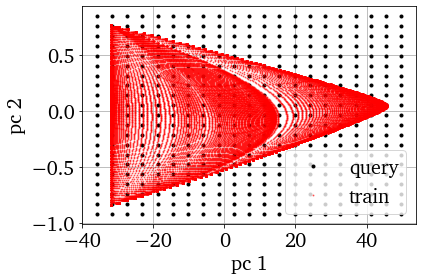

In [5]:
res = 21 # resolution of grid
ranges = np.max(pcVars, axis=0) - np.min(pcVars, axis=0) # range over whice PCs vary
pct = 0.05 # will extend the boundaries by pct*range

# creating meshgrid...
p1 = np.linspace(np.min(pcVars[:,0])-pct*ranges[0],np.max(pcVars[:,0])+pct*ranges[0],res)
p2 = np.linspace(np.min(pcVars[:,1])-pct*ranges[1],np.max(pcVars[:,1])+pct*ranges[1],res)
pcMesh = np.meshgrid(p1, p2, indexing='xy')

# defining query points for KReg...
query = np.vstack((pcMesh[0].ravel(), pcMesh[1].ravel())).T
print('query shape',query.shape)

# plotting...
plt.plot(query[:,0], query[:,1],'k.',label='query')
plt.plot(pcVars[:,0], pcVars[:,1],'r.',markersize=2, alpha=0.5, label='train')
plt.xlabel('pc 1')
plt.ylabel('pc 2')
plt.grid()
plt.legend()
plt.show()


### Now demonstrate how magnetism affects the source term regression.

Streamplot allows us to see the direction the vectors are pointing (which way the source term model will push the solution). Remember $\beta=0$ is "normal" kernel regression. Larger $\beta$ values pull the source term vectors toward the training manifolds more; these larger $\beta$ values can also start to skew the predictions **on** the training manifold though.

I'm using a bandwidth computed for the 3 nearest neighbors of each query point below.

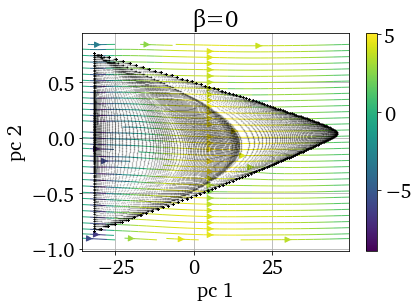

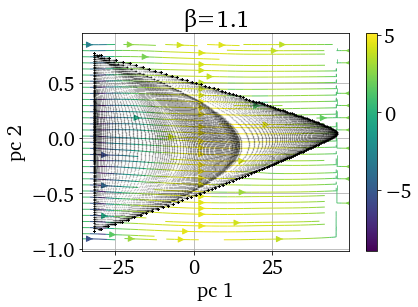

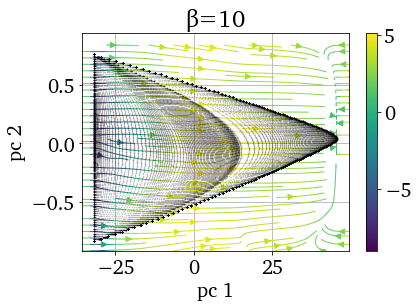

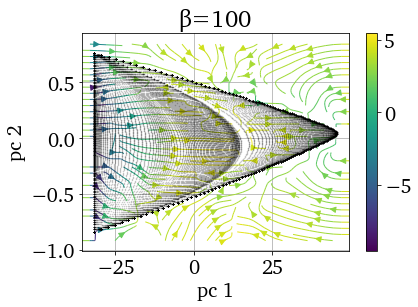

In [6]:
# can color the vectors using options below...
# have color by log10 of source term vector length; color by first source term component; and color by second source term component 

for beta in [0, 1.1, 10, 100]: # values of beta to loop over
    pred = kmod.predict_magnetism(query,'nearest_neighbors_isotropic', beta, n_neighbors=3) # kernel regression with extra magnetism term
    plt.streamplot(pcMesh[0], 
                   pcMesh[1], 
                   pred[:,0].reshape(pcMesh[0].shape), 
                   pred[:,1].reshape(pcMesh[1].shape),
                   
                   color=np.log10(np.linalg.norm(pred,axis=1)).reshape(pcMesh[1].shape), # color by log10 of source term vector length
#                    color=(pred[:,0]).reshape(pcMesh[1].shape), # color by first source term component
#                    color=(pred[:,1]).reshape(pcMesh[1].shape), # color by second source term component
                   
                   density=1.1,
                   linewidth=1,
                   arrowsize=1.3)
    plt.colorbar()
    plt.plot(pcVars[:,0], pcVars[:,1],'k.',markersize=1, alpha=0.2, label='train')
    plt.grid()
    plt.title(r'$\beta$='+str(beta))
    plt.xlabel('pc 1')
    plt.ylabel('pc 2')
    plt.show()


### Thoughts:

One thing we have thought about is if we can determine the boundary of the training data, then we could only apply the magnetism where it is needed (outside that boundary). We want something that isn't going to mess with the source term predictions on the training manifold but also help push the solution back toward the training manifold if we fall off. We don't want to push back to the manifold **too** fast though because that introduces stiffness for the numerics. We may not have the best form for the magnetism either...that could be changed.
